<a href="https://colab.research.google.com/github/capital00h/Anime_Face_StyleGAN2/blob/main/animetry3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Anime Face Using StyleGAN2

##Mounting Gdrive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Importing tensorflow

It is Requested to change Runtime from ```None``` to ```GPU```.
we are using Tensorflow 1.x

In [2]:
%tensorflow_version 1.x
import tensorflow as tf

TensorFlow 1.x selected.


### Version Check 

In [3]:
print('Tensorflow version: {}'.format(tf.__version__) )

Tensorflow version: 1.15.2


##Cloning sylegan2 from github

In [4]:
!git clone https://github.com/NVlabs/stylegan2.git

Cloning into 'stylegan2'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 138 (delta 4), reused 10 (delta 4), pack-reused 127
Receiving objects: 100% (138/138), 599.47 KiB | 14.27 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [5]:
%cd /content/stylegan2

/content/stylegan2


##Installing google_driver_downloader

In [6]:
!pip install googledrivedownloader

##Using pretrained_networks

Remove the multi line coment ```''' ''''``` to use gdrive downloader.
sometimes it doesnot work, in that case 
1. one have to download the ```.pkl``` file using the link ```https://drive.google.com/file/d/1WNQELgHnaqMTq3TlrnDaVkyrAH8Zrjez/view``` .
2. Mount the location of ```.pkl``` directly from grive to network_pkl.

In [7]:
import pretrained_networks
from google_drive_downloader import GoogleDriveDownloader as gdd

'''url = 'https://drive.google.com/open?id=1BHeqOZ58WZ-vACR2MJkh1ZVbJK2B-Kle'
#'https://drive.google.com/open?id=1WNQELgHnaqMTq3TlrnDaVkyrAH8Zrjez'
#'https://drive.google.com/open?id=1BHeqOZ58WZ-vACR2MJkh1ZVbJK2B-Kle'
url = url.replace("https://drive.google.com/open?id=", "")
model_id=url
network_pkl = '/content/models/model_1WNQELgHnaqMTq3TlrnDaVkyrAH8Zrjez.pkl'#(hashlib.md5(model_id.encode()).hexdigest())
gdd.download_file_from_google_drive(file_id=model_id,
                                    dest_path=network_pkl)
'''
network_pkl='/content/drive/MyDrive/models/network-snapshot-018528.pkl'
gdd.download_file_from_google_drive(file_id='network-snapshot-018528.pkl',
                                   dest_path=network_pkl)

_G, _D, Gs = pretrained_networks.load_networks(network_pkl)

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


##generate_z_vectors_from_seeds

random seeds are created using random function.

In [8]:
import numpy as np

def generate_z_vectors_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

In [9]:
import dnnlib
import dnnlib.tflib as tflib
import PIL.Image
from tqdm import tqdm

# Get tf noise variables, for the stochastic variation
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

# Truncation psi value needed for the truncation trick
# The most important hyperparameter for all StyleGAN generation
# Basically computing a sort of average face and scaling deviation from it 
def generate_images(zs, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    for z_idx, z in tqdm(enumerate(zs)):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
        
    # Return array of PIL.Image
    return imgs

def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_z_vectors_from_seeds(seeds), truncation_psi)

##Creating One image

[3899936]


1it [00:06,  6.26s/it]


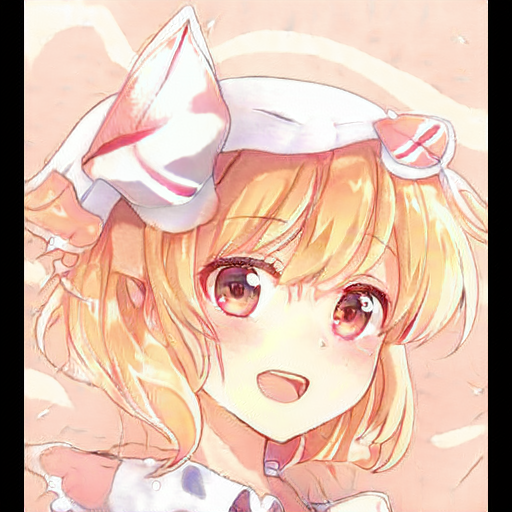

In [10]:
def createOneImage():
  seed = np.random.randint(10000000, size = 1)
  print(seed)

  # Our key variable to tweak
  psi = .7

  zs = generate_z_vectors_from_seeds(seed)
  imgs = generate_images(zs, psi)
  w = 512
  h = 512
  canvas = PIL.Image.new('RGBA', (w,h), 'white')
  image = imgs[0].resize((w,h), PIL.Image.ANTIALIAS)
  canvas.paste(image)
  return canvas 

createOneImage()

##Creating a matrix of images.

[8929845 3446833 8109672 4389559  790752 6296411 3894562 6441558 9597938]


9it [00:01,  6.88it/s]


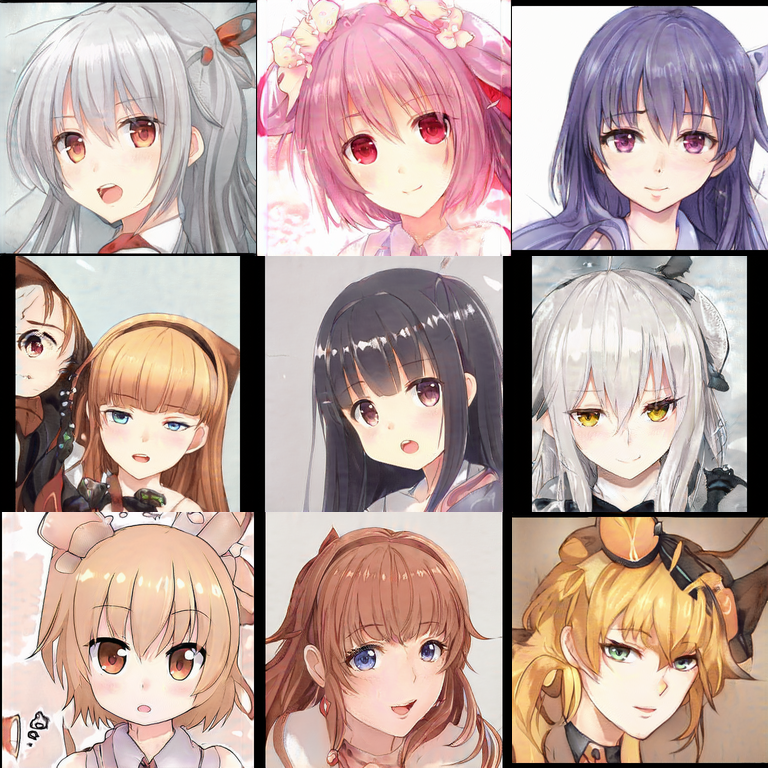

In [11]:
from os import posix_fadvise
from math import ceil

def createImageGrid(rows=1, scale=0.5, size = 9, psi = 0.7):
    # Generate images
    seeds = np.random.randint(10000000, size= size)
    print(seeds)

    psi = psi
    zs = generate_z_vectors_from_seeds(seeds)
    images = generate_images(zs, psi)

    # Display images in a grid
    w,h = images[0].size
    w = int(w*scale)
    h = int(h*scale)
    height = rows*h
    cols = ceil(len(images) / rows)
    width = cols*w
    canvas = PIL.Image.new('RGBA', (width,height), 'blue')
    for i,img in enumerate(images):
      img = img.resize((w,h), PIL.Image.ANTIALIAS)
      canvas.paste(img, (w*(i % cols), h*(i // cols))) 
    return canvas

createImageGrid(3, 0.5, 9,0.7)